In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%reload_ext blackcellmagic

# KMNIST Data Set - Exploration
This notebook is based _heavily_ on [this Kaggle kernel](https://www.kaggle.com/aakashnain/kmnist-mnist-replacement).

## Imports

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
import tensorflow as tf
from sklearn.utils import resample

np.random.seed(2019)
tf.set_random_seed(2019)

/Users/bendik/.local/share/virtualenvs/Kuzushiji-MNIST-5x822X8t/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


## Loading data files

In [3]:
input_path = Path("data")
kmnist_train_images_path = input_path / "kmnist-train-imgs.npz"
kmnist_train_labels_path = input_path / "kmnist-train-labels.npz"
kmnist_test_images_path = input_path / "kmnist-test-imgs.npz"
kmnist_test_labels_path = input_path / "kmnist-test-labels.npz"

classmap = pd.read_csv(input_path / "kmnist_classmap.csv")
label_char_mapping = dict(zip(classmap["index"], classmap["char"]))

kmnist_train_images = np.load(kmnist_train_images_path)["arr_0"]  # arr_0 is only key
kmnist_train_labels = np.load(kmnist_train_labels_path)["arr_0"]
kmnist_test_images = np.load(kmnist_test_images_path)["arr_0"]
kmnist_test_labels = np.load(kmnist_test_labels_path)["arr_0"]

print(label_char_mapping)
kmnist_test_images.shape, kmnist_train_images.shape

{0: 'お', 1: 'き', 2: 'す', 3: 'つ', 4: 'な', 5: 'は', 6: 'ま', 7: 'や', 8: 'れ', 9: 'を'}


((10000, 28, 28), (60000, 28, 28))

## Distributions 

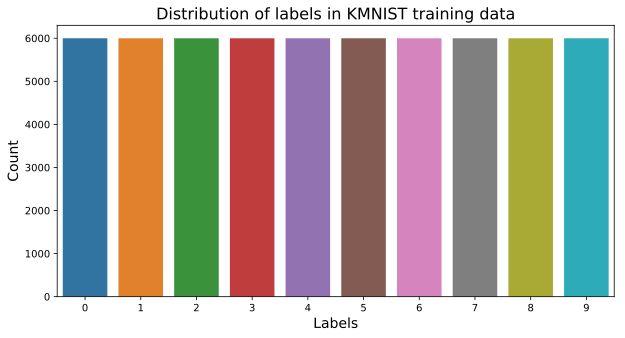

In [4]:
# Get the unique labels
labels = np.unique(kmnist_train_labels)
n_labels = len(labels)

# Get the frequency count for each label
frequency_count = np.bincount(kmnist_train_labels)

# Visualize 
plt.figure(figsize=(10,5))
sns.barplot(x=labels, y=frequency_count);
plt.title("Distribution of labels in KMNIST training data", fontsize=16)
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

## Looking at some samples for each label

(10, 3, 28, 28)


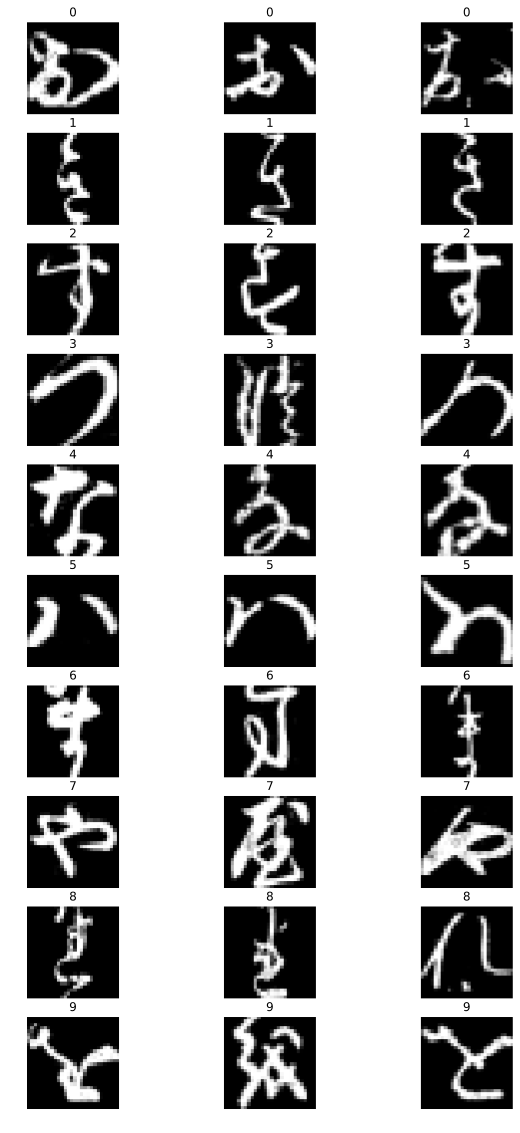

In [5]:
# Get 3 samples of each label (10 different)
n_samples = 3
random_samples = np.array(
    [kmnist_train_images[kmnist_train_labels == i][:n_samples] for i in range(n_labels)]
)
print(random_samples.shape)

# Visualize the samples
f, ax = plt.subplots(n_labels, n_samples, figsize=(10, 2*n_labels))
for i, j in enumerate(random_samples):
    for k in range(3):
        ax[i, k].imshow(random_samples[i][k, :, :], cmap="gray")
        ax[i, k].set_title(str(i))
        ax[i, k].axis("off")
        ax[i, k].set_aspect("equal")
        
plt.show()

## Embedding using UMAP

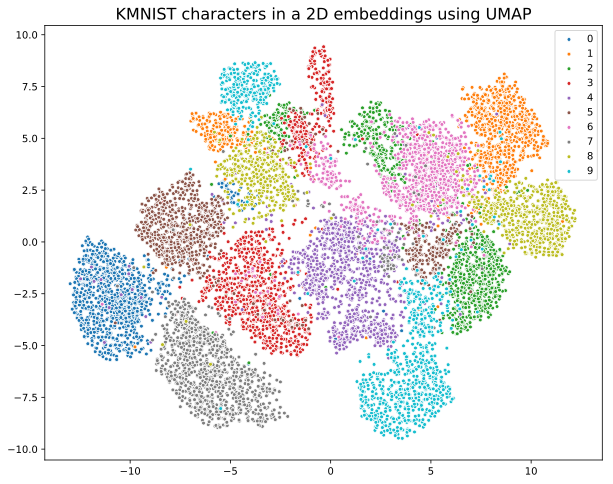

In [6]:
def resample_and_format_for_embedding(n_samples):
    images, labels = resample(
        kmnist_train_images,
        kmnist_train_labels,
        n_samples=min(n_samples, len(kmnist_train_images)),
        replace=False,
    )  # Select random samples
    images = images.astype(float) / np.max(images)  # Scale into [0, 1]
    images = images.reshape(n_samples, -1)  # Flatten images
    return images, labels


n_samples = 10000
train_images, train_labels = resample_and_format_for_embedding(n_samples)

embedding = umap.UMAP(n_components=2, metric="correlation", min_dist=0.8)
umap_2D = embedding.fit_transform(train_images)

fig, ax = plt.subplots(figsize=(10, 8))
for label in np.unique(train_labels):
    sns.scatterplot(*umap_2D[train_labels == label, :].T, label=label, s=15)
plt.title("KMNIST characters in a 2D embeddings using UMAP", fontsize=16)
plt.legend()
plt.show()

We see that the embedding is quite succesful, and therefore any good model should be able to do a significant level of learning. _However_, the groups are much less separated for KMNIST compared with regular MNIST, so will be harder.

## Training CNN

In [12]:
batch_size = 256
num_classes = 10
epochs = 3

# Process the train and test data in the exact same manner as done for MNIST
x_train = kmnist_train_images.astype('float32') / 255
x_test = kmnist_test_images.astype('float32') / 255

x_train = x_train.reshape(*x_train.shape, 1)
x_test = x_test.reshape(*x_test.shape, 1)

print(x_train.shape, x_test.shape)


# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(kmnist_train_labels, n_labels)
y_test = tf.keras.utils.to_categorical(kmnist_test_labels, n_labels)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [13]:
# Build and train the model.
model = tf.keras.models.Sequential()
model.add(
    tf.keras.layers.Conv2D(
        32, kernel_size=(3, 3), activation="relu", input_shape=x_train.shape[1:]
    )
)
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Some random things break in Python 3.7 due to https://github.com/tensorflow/tensorflow/issues/20444
# Expected to be fixed once 3.7 support is released properly.
# model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation="relu"))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(n_labels, activation="softmax"))

model.compile(
    loss="categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"]
)

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 177s 3ms/step - loss: 0.4557 - acc: 0.8610 - val_loss: 0.3880 - val_acc: 0.8849
Epoch 2/3
60000/60000 [==============================] - 166s 3ms/step - loss: 0.1110 - acc: 0.9676 - val_loss: 0.3403 - val_acc: 0.9055
Epoch 3/3
60000/60000 [==============================] - 164s 3ms/step - loss: 0.0638 - acc: 0.9807 - val_loss: 0.3131 - val_acc: 0.9098


In [15]:
score = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]*100}%")

Test loss: 0.3131307421803474
Test accuracy: 90.98%


This model overfits (for enough epochs, not for 3) due to the missing dropout layers, which couldn't be used on Python 3.7 (as of Feb 2019).